# Random Forest, Decision Tree and Neural Network

This is a notebook for testing random forest, decison tree and neural network on the dataset we are given for the W207 final project. Currently only random forest and decision tree are included. Will work on Nerual Network in the week of 7/15.

In addition, this notebook included some additional notes on classifying the dataset using multinomial naive bayes.

Import the packages needed.

In [14]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

Read the data, shuffle and split it into training and testing sets in 70%, 30% split.

In [9]:
with open('forest-cover-type-prediction/train.csv', 'rt') as f:
    reader = csv.reader(f)
    header = next(reader)

In [10]:
my_data = np.genfromtxt('forest-cover-type-prediction/train.csv', delimiter=',')

In [11]:
data = my_data[1:, 1:my_data.shape[1]-1]  # avoid getting headers and ID column
labels = my_data[1:,-1]

In [21]:
# shuffle the training data
np.random.seed(0)

shuffle = np.random.permutation(np.arange(data.shape[0]))

shuffled_data = data[shuffle]
shuffled_labels = labels[shuffle]
shuffled_labels = shuffled_labels - 1

# split the data to 60% train, 20% dev and 20% test
num_train = int(shuffled_data.shape[0]*0.6)
num_dev = int(shuffled_data.shape[0]*0.8)

train_data, train_labels = shuffled_data[:num_train], shuffled_labels[:num_train]
dev_data, dev_labels = shuffled_data[num_train:num_dev], shuffled_labels[num_train:num_dev]
test_data, test_labels = shuffled_data[num_dev:], shuffled_labels[num_dev:]

### Random Forest, Decision Tree and Adaboost

Without any feature engineering and optimization, use the above three classifier on the dataset.

In [22]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(train_data, train_labels)

print('Accuracy (a decision tree):', dt.score(dev_data, dev_labels))

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_data, train_labels)

print('Accuracy (a random forest):', rfc.score(dev_data, dev_labels))

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

abc.fit(train_data, train_labels)
print('Accuracy (adaboost with decision trees):', abc.score(dev_data, dev_labels))

Accuracy (a decision tree): 0.7751322751322751
Accuracy (a random forest): 0.8465608465608465
Accuracy (adaboost with decision trees): 0.41898148148148145


Out of the box, random forest seems to have really good accuracy.

### Naive Bayes Considerations

Though


1. How to deal with the continuous variables:
    * bucketing by percentiles
    * bucketing by int(np.log())
    * bucketing by fixed width buckets

In [6]:
def bucket_data_percentile(data, bucket):
    '''This function transform continuous data into discrete data by putting them into buckets of base on percentile'''

    lower_bound = np.min(data)
    bucketed_data = np.empty((data.shape[0],0))

    for i in range(1, bucket+1):
#         print(i, bucket)
        upper_bound = np.percentile(data, 100*i/bucket)
#         print(lower_bound, upper_bound)
        col = i * (data >= lower_bound) * (data < upper_bound)
        bucketed_data = np.hstack((bucketed_data,col.reshape(data.shape[0],1)))
        lower_bound = upper_bound

    output_data = np.sum(bucketed_data, axis=1)
#     print(output_data)

    return output_data.reshape(output_data.size,1)

In [7]:
def bucket_data_con_interval(data, bucket):
    '''This function transform continuous data into discrete data by putting them into buckets of constant intervals'''

    lower_bound = np.min(data)
    bucketed_data = np.empty((data.shape[0],0))

    for i in range(1, bucket+1):
        
        upper_bound = lower_bound+(np.max(data) - np.min(data))/bucket
        col = i * (data >= lower_bound) * (data < upper_bound)
        bucketed_data = np.hstack((bucketed_data,col.reshape(data.shape[0],1)))
        lower_bound = upper_bound

    output_data = np.sum(bucketed_data, axis=1)

    return output_data.reshape(output_data.size,1)

In [8]:
def bucket_data_log(data, bucket):
    return np.log(np.absolute(data)+1).astype('int').reshape(data.size,1)

In [9]:
def bucket_data(data, cols, bucket_method, bucket_num):
    transformed_data = np.empty((data.shape[0], 0))

    for i in range(data.shape[1]):
#         print(i)
        if i not in cols:
            transformed_data = np.hstack((transformed_data, data[:,i].reshape(data.shape[0],1)))
        else:
            transformed_data = np.hstack((transformed_data, bucket_method(data[:,i],bucket_num)))
    
    return transformed_data

In [10]:
discrete_train_data = bucket_data(train_data, range(10), bucket_data_con_interval, 7)
# discrete_train_data = bucket_data(train_data, range(10), bucket_data_log, None)


mnb = MultinomialNB()
# mnb.fit(discrete_train_data, train_labels)

alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20.0, 30.0]}

grid_search = GridSearchCV(mnb, alphas, cv=5)
    
# fit the data
grid_search.fit(discrete_train_data, train_labels)

# report the results 
print('The best alpha is:', grid_search.best_params_['alpha'])
print('-'*50)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     if params['alpha'] == 0 or params['alpha'] == grid_search.best_params_['alpha']:
    print('alpha =', '%s,' %params['alpha'], 'Accuracy = ', mean_score)

The best alpha is: 1.0
--------------------------------------------------
alpha = 0.0001, Accuracy =  0.6027966742252456
alpha = 0.001, Accuracy =  0.6027966742252456
alpha = 0.01, Accuracy =  0.6027966742252456
alpha = 0.1, Accuracy =  0.6027966742252456
alpha = 0.5, Accuracy =  0.6030801209372638
alpha = 1.0, Accuracy =  0.6033635676492819
alpha = 2.0, Accuracy =  0.6030801209372638
alpha = 10.0, Accuracy =  0.6027021919879063
alpha = 20.0, Accuracy =  0.600151171579743
alpha = 30.0, Accuracy =  0.5971277399848829


In [11]:
# Test the fit to predict on training data

discrete_train_data = bucket_data(train_data, range(10), bucket_data_con_interval, 7)
mnb = MultinomialNB()
mnb.fit(discrete_train_data, train_labels)

predictions = mnb.predict(discrete_train_data)

metrics.accuracy_score(train_labels, predictions)

0.6098828420256992

* The classifier is underfitted

In [12]:
# Try to add the interaction of two features as a new feature

interactions = train_data[:,0] * train_data[:,5]
interactions = interactions.reshape(train_data.shape[0],1)
expanded_train_data = np.hstack((train_data, interactions))
# print(interactions)

In [13]:
# test fit

indices = [i for i in range(10)] + [expanded_train_data.shape[1]-1]
# print(indices)
discrete_train_data = bucket_data(expanded_train_data, indices, bucket_data_percentile, 7)

# print(discrete_train_data[:, -1])

mnb = MultinomialNB()
mnb.fit(discrete_train_data, train_labels)

predictions = mnb.predict(discrete_train_data)

metrics.accuracy_score(train_labels, predictions)

0.6152683295540439

(array([    0.,     0.,     0.,     0.,     0., 10584.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

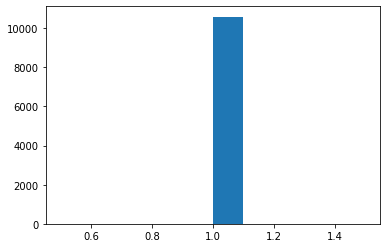

In [14]:
soil_sum = np.sum(train_data[:, 14:], axis = 1)

plt.hist(soil_sum)

* Only one soil is one per example

### Neural Network (will work on this in the week of 7/15)

In [15]:
%matplotlib inline

import numpy as np

from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print(theano.config.device) # We're using CPUs (for now)
print(theano.config.floatX) # Should be 64 bit for CPUs
np.random.seed(0)

cpu
float64


In [16]:
def binarizeY(data):
    binarized_data = np.zeros((data.size,7))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64)
        binarized_data[j,i]=1
    return binarized_data
train_labels_b = binarizeY(train_labels)
dev_labels_b = binarizeY(dev_labels)
numClasses = train_labels_b[1].size
# print('Classes = %d' %(numClasses))

# print(train_labels_b[:20])